In [86]:
#Homework 5
# Hina Suzuki

In [87]:
from CenterOfMass import CenterOfMass
from ReadFile import Read 
import matplotlib as plt 
import astropy.units as u
from astropy.constants import G
import numpy as np
import matplotlib.pyplot as plt

In [88]:
class MassProfile: 
    def __init__(self, galaxy, Snap):
        ''' Class to determine the mass distribution of each galacy at SnapNumber 0. 
            
            PARAMETERS
            ----------
            galaxy : `str`
                name of galaxy. (e.g. "MW", "M31" )
            Snap : `int; 1, 2, or 3`
                snapshot number 
        ''' 
        
        # add a string of the filenumber to the value “000”
        ilbl = '000' + str(Snap)
        # remove all but the last 3 digits
        ilbl = ilbl[-3:]
        self.filename="%s_"%(galaxy) + ilbl + '.txt'
        
        self.time, self.total, self.data = Read(self.filename)  
        
        # read data for the positions and mass 
        # x,y,z positions in kpc.
        self.m = self.data['m']
        self.x = self.data['x'] 
        self.y = self.data['y'] 
        self.z = self.data['z'] 
        
        # store the name of galaxy 
        self.gname = galaxy 
        
        # gravitational constant
        self.G = G.to(u.kpc*u.km**2/u.s**2/u.Msun)
       
    def MassEnclosed(self, ptype, rmax):
        '''Function to calculate the mass enclosed within a given radius of the COM postion 
        for specified galaxy and specified components of that galaxy. 
        
        Input: 
            ptype : 'int'
                particle tyle
            rmax : 'np.ndarray'
                magnitudes of radii to calculate the mass enclosed 
                
        Output : 
            m_enclosed : 'np.array'
                array of mass enclosed, in M_sun
        '''
        
        # determine the center of mass with disk particles
        G_COM = CenterOfMass(self.filename, 2)
        G_COM_p = G_COM.COM_P(0.1)
        
        size = rmax.size
        
        # create array for return 
        m_enclosed = []
        
        # store index of ptype particles 
        index = np.where( self.data['type'] == ptype  )
        
        x = self.x[index] - G_COM_p[0].value
        y = self.y[index] - G_COM_p[1].value
        z = self.z[index] - G_COM_p[2].value
        mass = self.m[index]
        mag_r = np.sqrt(x**2 + y**2 + z**2) 
        
        # iterate over rmax to calculate mass enclosed 
        for i in range(size): 
            # store index of particles within radius
            mass_in = np.where( mag_r < rmax[i] ) 
            # append sum of masses  
            m_enclosed.append( mass[mass_in].sum() * 1e10 )  
            
        # assign unit 
        return m_enclosed * u.Msun 
        
    def MassEnclosedTotal(self, radii): 
        '''
        Function to compute the mass enclosed within the radius array for each particle type. 

        Input: 
            radii (1D array)
                array of radius
        Output: 
            array of masses 
                total enclosed mass in Msun
        '''
        # create array for ptype for iteration, M33 have special case 
        if self.gname == 'M33': 
            ptype = [1,2]
        else: 
            ptype = [1,2,3]
       
    
        total_m = 0
        # iterate calculation of mass enclosed for all particle types per radius 
        for t in range( len(ptype)) : 
            total_m += self.MassEnclosed(ptype[t], radii)
            
        # unit already assigned in mass enclosef function 
        return total_m 


    def HernquistMass(self, radius, a, Mhalo):
        ''' Function to compute the mass enclosed within a given radius 
        using the following equation.
            M = Mhalo * radius*2 / (a + radius )**2
        Input: 
            radius: 'float'
                radius of where you calculate mass enclosed to
            a: 'float'
                scale factor
            Mhalo: 'float'
                halo mass 

        Output: 
               Hernquise mass in Msun
        '''
        
        Menclosed_a = (Mhalo * u.Msun) * radius **2 
        Menclosed_b = (a + radius)**2        
        
        return Menclosed_a/Menclosed_b 
    
    def CircularVelocity(self, ptype, radii): 
        '''Compute circular velocity assuming spherical symmetry. 
        v = np.sqrt( GM /R )
        Input: 
            ptype: 'int' 
                particle type 
            radii: 'array'
                array of radius
        '''
        # get mass enclosed for each radii, given particle type
        M = self.MassEnclosed(ptype, radii)
        
        # calculate circular velocity
        cvel =  np.sqrt( self.G * M/ (radii * u.kpc) ) 
        
        # round into 2 decimal places and return
        return np.round( cvel , 2) 
    
    def CircularVelocityTotal(self, radii):
        '''Create an array of circular veloctiy calculated with all particle types 
        at given radius.
        Input: 
            radii: 'array' 
                array of radius
        Output: 
            array of circular velocity in km/s
        '''
        
        tot_m = self.MassEnclosedTotal(radii)  # total mass enclosed for given radii
        
        # calculate circular velocity with total mass enclosed
        tot_vel = np.sqrt(self.G* tot_m / (radii*u.kpc) ) 
        
        # round into 2 decimal places and return
        return np.round( tot_vel, 2) 
    
    def HernquistVCirc(self, radius, a, Mhalo):
        '''Calculate circular speed by using Hernquist mass. 
        Input: 
            radius: 'float'
                radius of where you calculate mass enclosed to
            a: 'float'
                scale factor
            Mhalo: 'float'
                halo mass 

        Output: 
            cicular velosity in km/s
        '''
        # calculate Hernquistmass 
        mass = self.HernquistMass( radius, a, Mhalo) 
        # calculate circular velocity with hernquist mass 
        cvel =  np.sqrt( self.G* tot_m /R )
        
        # round into 2 decimal places and assign unit
        return np.round( cvel * u.km / u.s ,2 ) 
                           

In [89]:
MW = MassProfile('MW', 0)
M31 = MassProfile('M31', 0)
M33 = MassProfile('M33', 0)

In [90]:
r = np.arange(0.1, 30, 1)

# 8. Plot the Mass Profile of each Galaxy

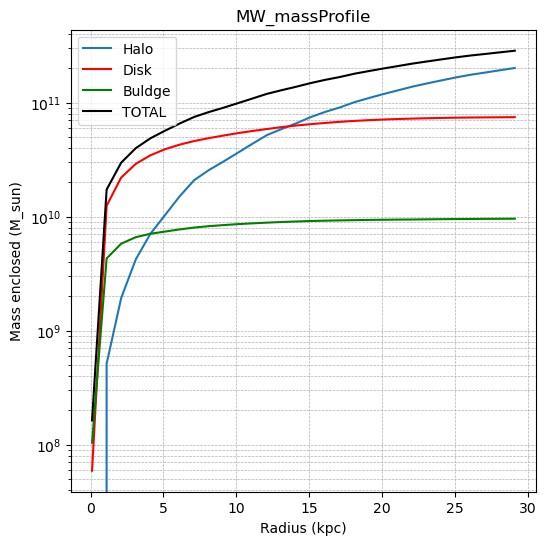

In [91]:
# sample data
y1 = MW.MassEnclosed(1, r)
y2 = MW.MassEnclosed(2, r)
y3 = MW.MassEnclosed(3, r)
y4 = MW.MassEnclosedTotal(r)

# Create figure
fig, ax = plt.subplots(figsize=(6, 6))

# Plot data with logarithmic y-axis
ax.plot(r, y1, label='Halo')
ax.plot(r, y2, label='Disk', color='r')
ax.plot(r, y3, label='Buldge', color='g')
ax.plot(r, y4, label='TOTAL', color='black')
ax.set_yscale('log')
ax.set_xlabel('Radius (kpc)')
ax.set_ylabel('Mass enclosed (M_sun)')
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show plot
plt.title("MW_massProfile")
plt.show()
plt.savefig("MW_massProfile.pdf")

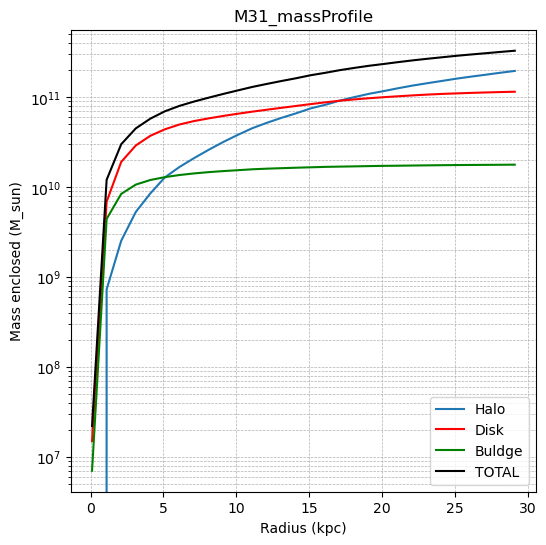

In [92]:
# sample data
y1 = M31.MassEnclosed(1, r)
y2 = M31.MassEnclosed(2, r)
y3 = M31.MassEnclosed(3, r)
y4 = M31.MassEnclosedTotal(r)

# Create figure
fig, ax = plt.subplots(figsize=(6, 6))

# Plot data with logarithmic y-axis
ax.plot(r, y1, label='Halo')
ax.plot(r, y2, label='Disk', color='r')
ax.plot(r, y3, label='Buldge', color='g')
ax.plot(r, y4, label='TOTAL', color='black')
ax.set_yscale('log')
ax.set_xlabel('Radius (kpc)')
ax.set_ylabel('Mass enclosed (M_sun)')
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show plot
plt.title("M31_massProfile")
plt.show()
plt.savefig("M31_massProfile.pdf")

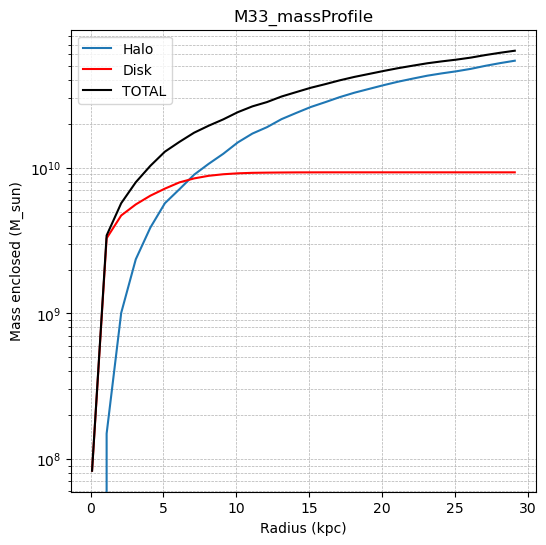

In [93]:
# sample data
y1 = M33.MassEnclosed(1, r)
y2 = M33.MassEnclosed(2, r)
y4 = M33.MassEnclosedTotal(r)

# Create figure
fig, ax = plt.subplots(figsize=(6, 6))

# Plot data with logarithmic y-axis
ax.plot(r, y1, label='Halo')
ax.plot(r, y2, label='Disk', color='r')
# ax.plot(r, y3, label='Buldge', color='g')
ax.plot(r, y4, label='TOTAL', color='black')
ax.set_yscale('log')
ax.set_xlabel('Radius (kpc)')
ax.set_ylabel('Mass enclosed (M_sun)')
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show plot
plt.title("M33_massProfile")
plt.show()
plt.savefig("M33_massProfile.pdf")

# 9. Plot the Rotation Curve for each Galaxy

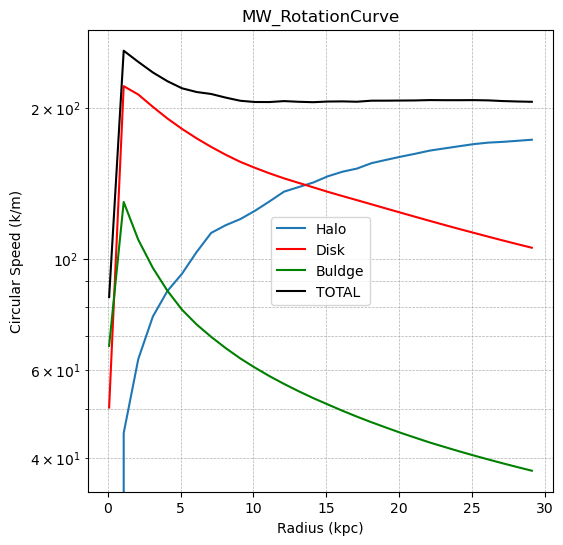

In [94]:
# sample data
y1 = MW.CircularVelocity(1, r)
y2 = MW.CircularVelocity(2, r)
y3 = MW.CircularVelocity(3, r)
y4 = MW.CircularVelocityTotal(r)

# Create figure
fig, ax = plt.subplots(figsize=(6, 6))

# Plot data with logarithmic y-axis
ax.plot(r, y1, label='Halo')
ax.plot(r, y2, label='Disk', color='r')
ax.plot(r, y3, label='Buldge', color='g')
ax.plot(r, y4, label='TOTAL', color='black')
ax.set_yscale('log')
ax.set_xlabel('Radius (kpc)')
ax.set_ylabel('Circular Speed (k/m)')
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show plot
plt.title("MW_RotationCurve")
plt.show()
plt.savefig("MW_RotationCurve.pdf")

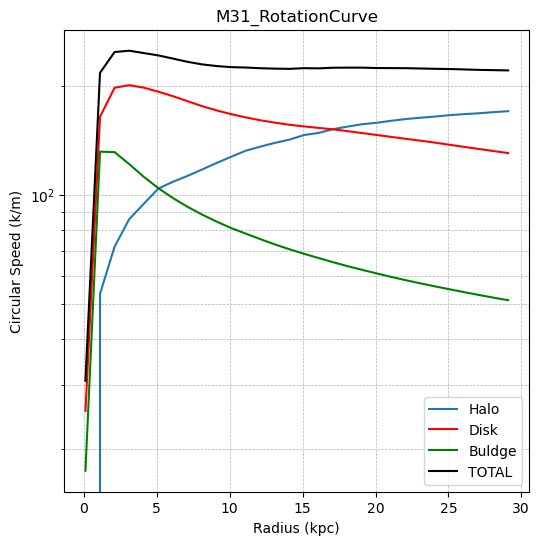

In [95]:
# sample data
y1 = M31.CircularVelocity(1, r)
y2 = M31.CircularVelocity(2, r)
y3 = M31.CircularVelocity(3, r)
y4 = M31.CircularVelocityTotal(r)

# Create figure
fig, ax = plt.subplots(figsize=(6, 6))

# Plot data with logarithmic y-axis
ax.plot(r, y1, label='Halo')
ax.plot(r, y2, label='Disk', color='r')
ax.plot(r, y3, label='Buldge', color='g')
ax.plot(r, y4, label='TOTAL', color='black')
ax.set_yscale('log')
ax.set_xlabel('Radius (kpc)')
ax.set_ylabel('Circular Speed (k/m)')
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show plot
plt.title("M31_RotationCurve")
plt.show()
plt.savefig("M31_RotationCurve.pdf")

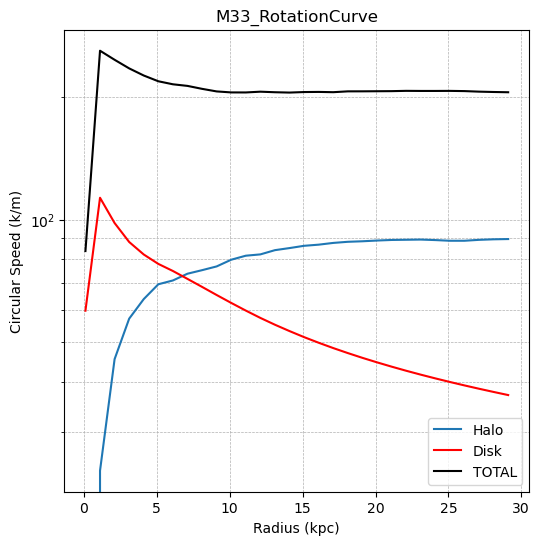

In [96]:
# sample data
y1 = M33.CircularVelocity(1, r)
y2 = M33.CircularVelocity(2, r)
# y3 = M33.CircularVelocity(3, r)
y4 = MW.CircularVelocityTotal(r)

# Create figure
fig, ax = plt.subplots(figsize=(6, 6))

# Plot data with logarithmic y-axis
ax.plot(r, y1, label='Halo')
ax.plot(r, y2, label='Disk', color='r')
# ax.plot(r, y3, label='Buldge', color='g')
ax.plot(r, y4, label='TOTAL', color='black')
ax.set_yscale('log')
ax.set_xlabel('Radius (kpc)')
ax.set_ylabel('Circular Speed (k/m)')
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show plot
plt.title("M33_RotationCurve")
plt.show()
plt.savefig("M33_RotationCurve.pdf")